Use TSNE and UMAP to visualize chemical space
UMAP 'Uniform Manifold Approximation and Projection' the method works faster than tSNE.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import umap
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha':0.5, 's':80, 'linewidth':0}

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import DataStructs
from rdkit.Chem.Draw import IPythonConsole

In [3]:
IPythonConsole.ipython_useSVG = True

Load SDF that from ChEMBL GSK3B and calculate Morgan FP

In [4]:
mols = [mol for mol in Chem.SDMolSupplier('gsk3b.sdf') if mol != None]
for mol in mols:
    AllChem.Compute2DCoords(mol)
X = []
for mol in mols:
    arr = np.zeros((0,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    DataStructs.ConvertToNumpyArray(fp, arr)
    X.append(arr)
print('{} mols loaded'.format(len(X)))

1867 mols loaded


Load hdbscan library and perform clustering

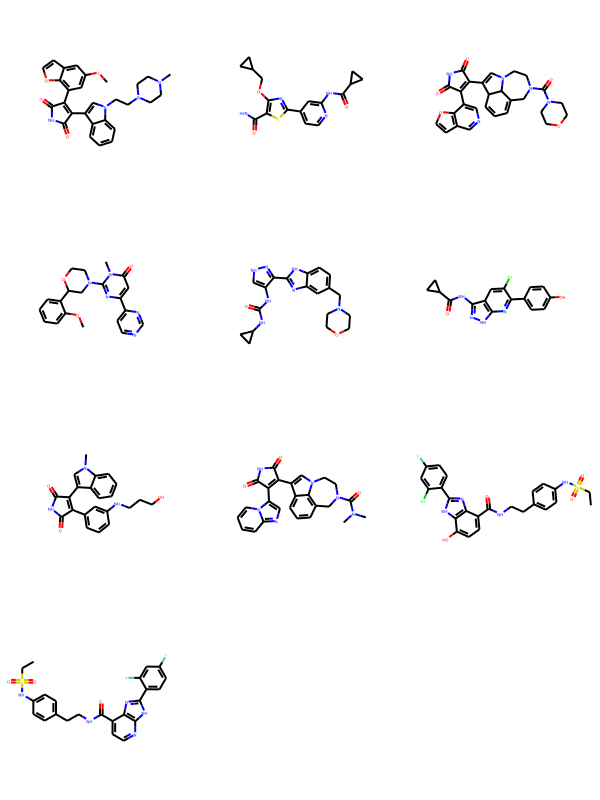

In [5]:
Draw.MolsToGridImage(mols[:10])

Reduce dimension by using tSNE / UMAP with default settings.

In [9]:
import numba

@numba.njit()
def tanimoto_dist(a,b):
    dotprod = np.dot(a,b)
    tc = dotprod / (np.sum(a) + np.sum(b) - dotprod)
    return 1.0-tc

In [11]:
tsne = TSNE(n_components=2, metric=tanimoto_dist)
tsne_X = tsne.fit_transform(X)
print(tsne_X.shape)

(1867, 2)


In [12]:
umap_X = umap.UMAP(n_neighbors=8, min_dist=0.3, metric=tanimoto_dist).fit_transform(X)

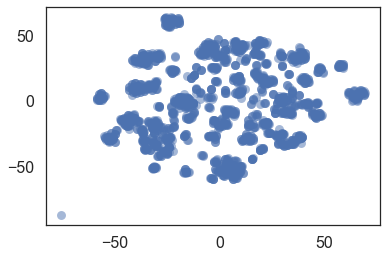

In [13]:
plt.scatter(tsne_X.T[0], tsne_X.T[1], color='b', **plot_kwds)

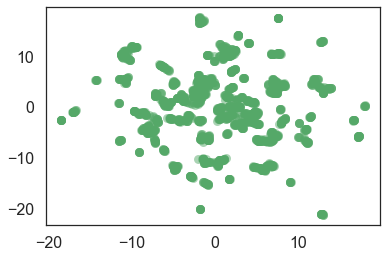

In [14]:
plt.scatter(umap_X.T[0], umap_X.T[1], color='g', **plot_kwds)

In [15]:
import hdbscan
cluster_tsne = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
cluster_umap = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)

In [16]:
cluster_tsne.fit(tsne_X)
cluster_umap.fit(umap_X)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

/Users/iwatobipen/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/hdbscan/plots.py:784: RuntimeWarning: divide by zero encountered in true_divide
  line_width = edge_linewidth * (np.log(self._mst.T[2].max() / self._mst.T[2]) + 1.0)


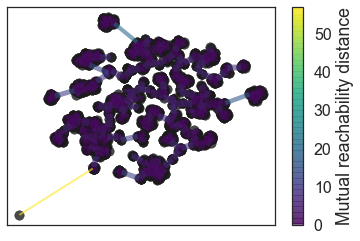

In [17]:
cluster_tsne.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                   edge_alpha=0.6,
                                   node_size=90,
                                   edge_linewidth=2)

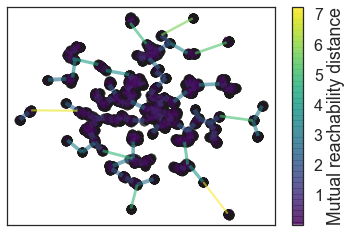

In [18]:
cluster_umap.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                   edge_alpha=0.6,
                                   node_size=90,
                                   edge_linewidth=2)

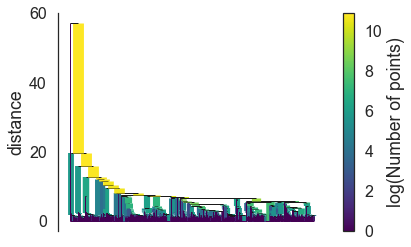

In [19]:
cluster_tsne.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

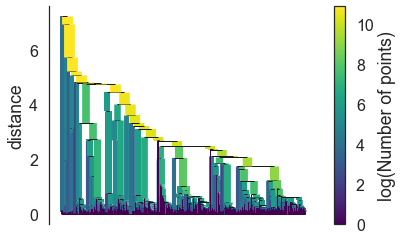

In [20]:
cluster_umap.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

In [21]:
palette = sns.color_palette() 
label_prob = zip(cluster_umap.labels_, cluster_umap.probabilities_)

Make scatter plot with label information that is generated by HDBSCAN


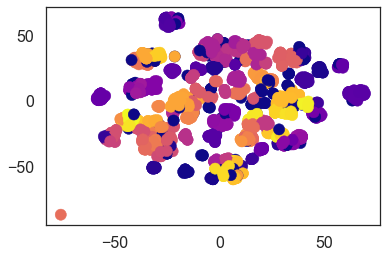

In [25]:
plt.scatter(tsne_X.T[0], tsne_X.T[1], c = cluster_umap.labels_, cmap='plasma')

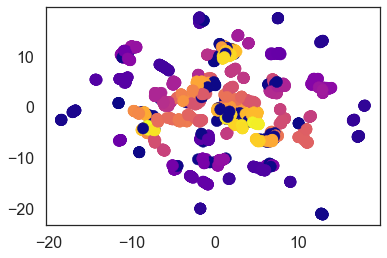

In [24]:
plt.scatter(umap_X.T[0], umap_X.T[1], c = cluster_umap.labels_, cmap='plasma')